In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import os

from PIL import *
import cv2
from functools import partial

import time
import math

import torch
from torch import nn
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.multiprocessing as mp
import pytorch_lightning as pl
from tqdm.cli import tqdm as tq

from statistics import mean
from typing import Tuple, Dict, Iterable

In [2]:
%load_ext autoreload

In [3]:
%reload_ext autoreload

In [4]:
autoreload 2

In [5]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 300

In [6]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [7]:
import torch
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.anchor_utils import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# MaskRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be ['0']. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                     output_size=14,
                                                     sampling_ratio=2)
# put the pieces together inside a MaskRCNN model
model = MaskRCNN(backbone,
                 num_classes=2,
                 rpn_anchor_generator=anchor_generator,
                 box_roi_pool=roi_pooler,
                 mask_roi_pool=mask_roi_pooler)
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

/Users/personal/Documents/Topics/Model training/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/personal/Documents/Topics/Model training/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
model = maskrcnn_resnet50_fpn(
    pretrained = True,
)

# Change number of output classes to two ( no-crater, crater )
in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor = FastRCNNPredictor( in_features, num_classes = 2 )

param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = ( param_size + buffer_size ) / (1200*1920)
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 76.478MB


In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [16]:
from exterres_dataset_mask import load_bounding_boxes, load_projected_ellipses, compute_mask

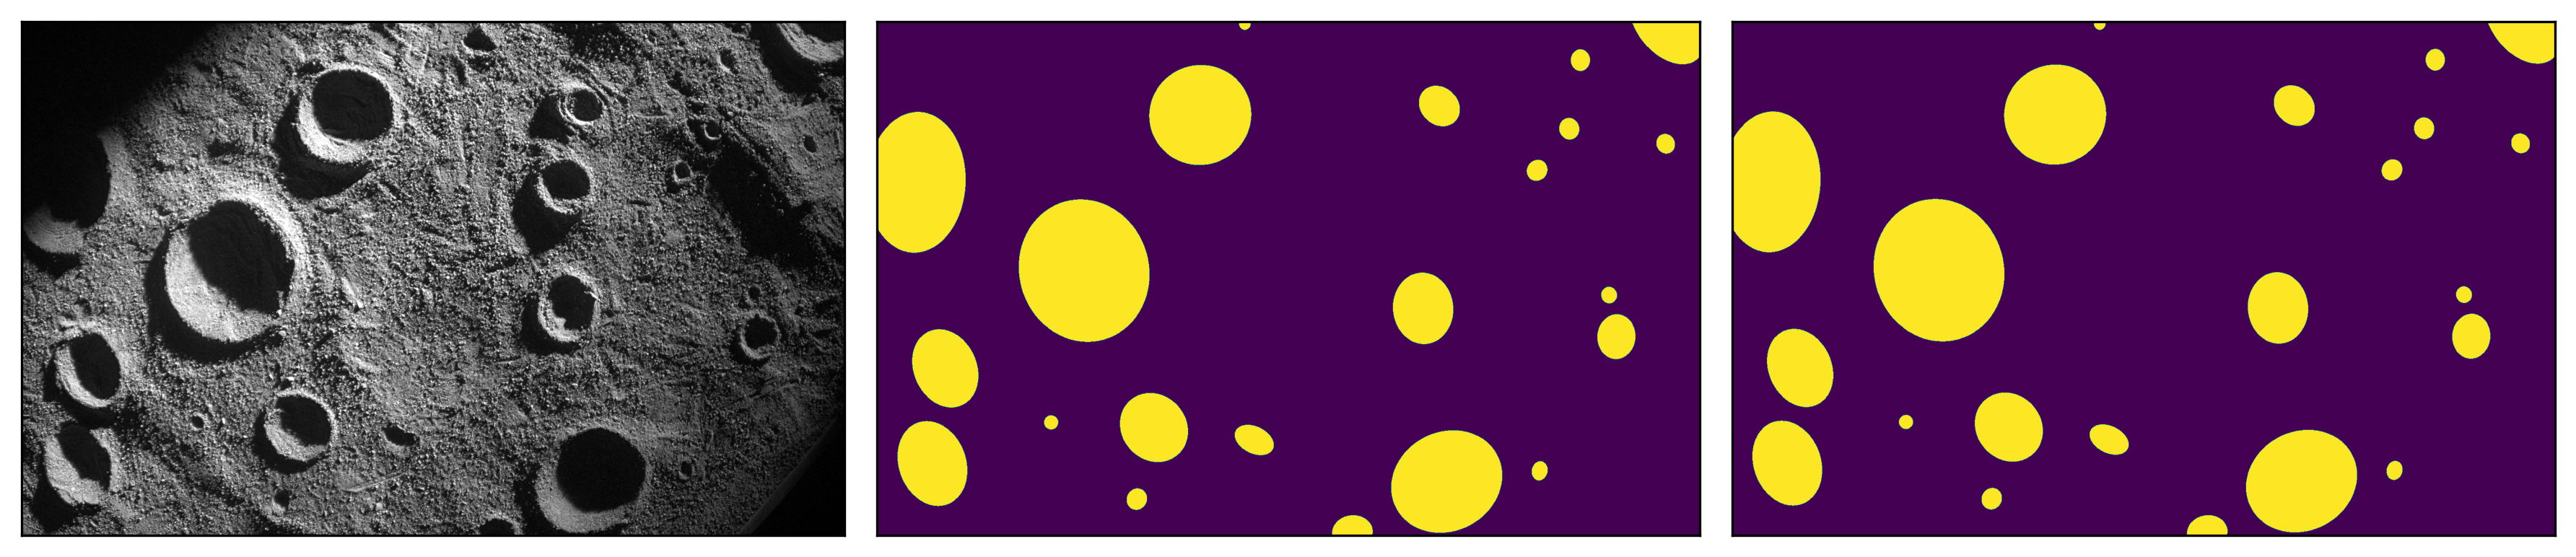

In [17]:
test_path = 'A2_ACW_frame306.png'

boxes = load_bounding_boxes( [test_path] )

ellipses = load_projected_ellipses( test_path)

masks = compute_mask( ( 1200, 1920 ), ellipses['ellipse_sparse'] )

fig, ax = plt.subplots( ncols = 3 )

img = Image.open('Craters/' + test_path)
ax[0].imshow(img)

# Second image is masks
img = np.zeros( ( 1200, 1920 ) )
for im in masks:
    img = img + im.numpy()
ax[1].imshow( img )

# Next show contours
ellipses = []
for im in masks:
    im = im.numpy()
    threshold = 0.5
    canny_output = cv2.Canny( cv2.merge( ( im, im, im ) ), threshold, threshold * 2 )
    contours, _ = cv2.findContours( canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE ) 
    
    for contour in contours:
        # Hopefully only ever one!
        if contour.shape[0] > 5:
            ellipses.append( cv2.fitEllipse( contour ) )

img = np.zeros( ( 1200, 1920 ) )
for ellipse in ellipses:
    cv2.ellipse(
        img,
        ( int( ellipse[0][0] ), int( ellipse[0][1] ) ),
        ( int( ellipse[1][0] / 2 ), int( ellipse[1][1] / 2 ) ),
        ellipse[2],
        0, # Start Angle for drawing
        360, # End Angle for drawing
        ( 1 ),
        -1, # Mask should be filled
    )
ax[2].imshow( img )

for i in range( 3 ):
    ax[i].set_xticks( [] )
    ax[i].set_yticks( [] )

fig.tight_layout()
plt.show()


In [18]:
# Create a list to hold the names of PNG files
craters = []

# Iterate through each file in the directory
for filename in os.listdir('Craters') :
    craters.append(filename)

In [19]:
# Build CDA database (typically takes about a minute)
from exterres_dataset_mask import CraterDataset

cd = CraterDataset( craters, ( 1200, 1920 ) )

Filter bad samples:
Total Images after Filtering 378


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].


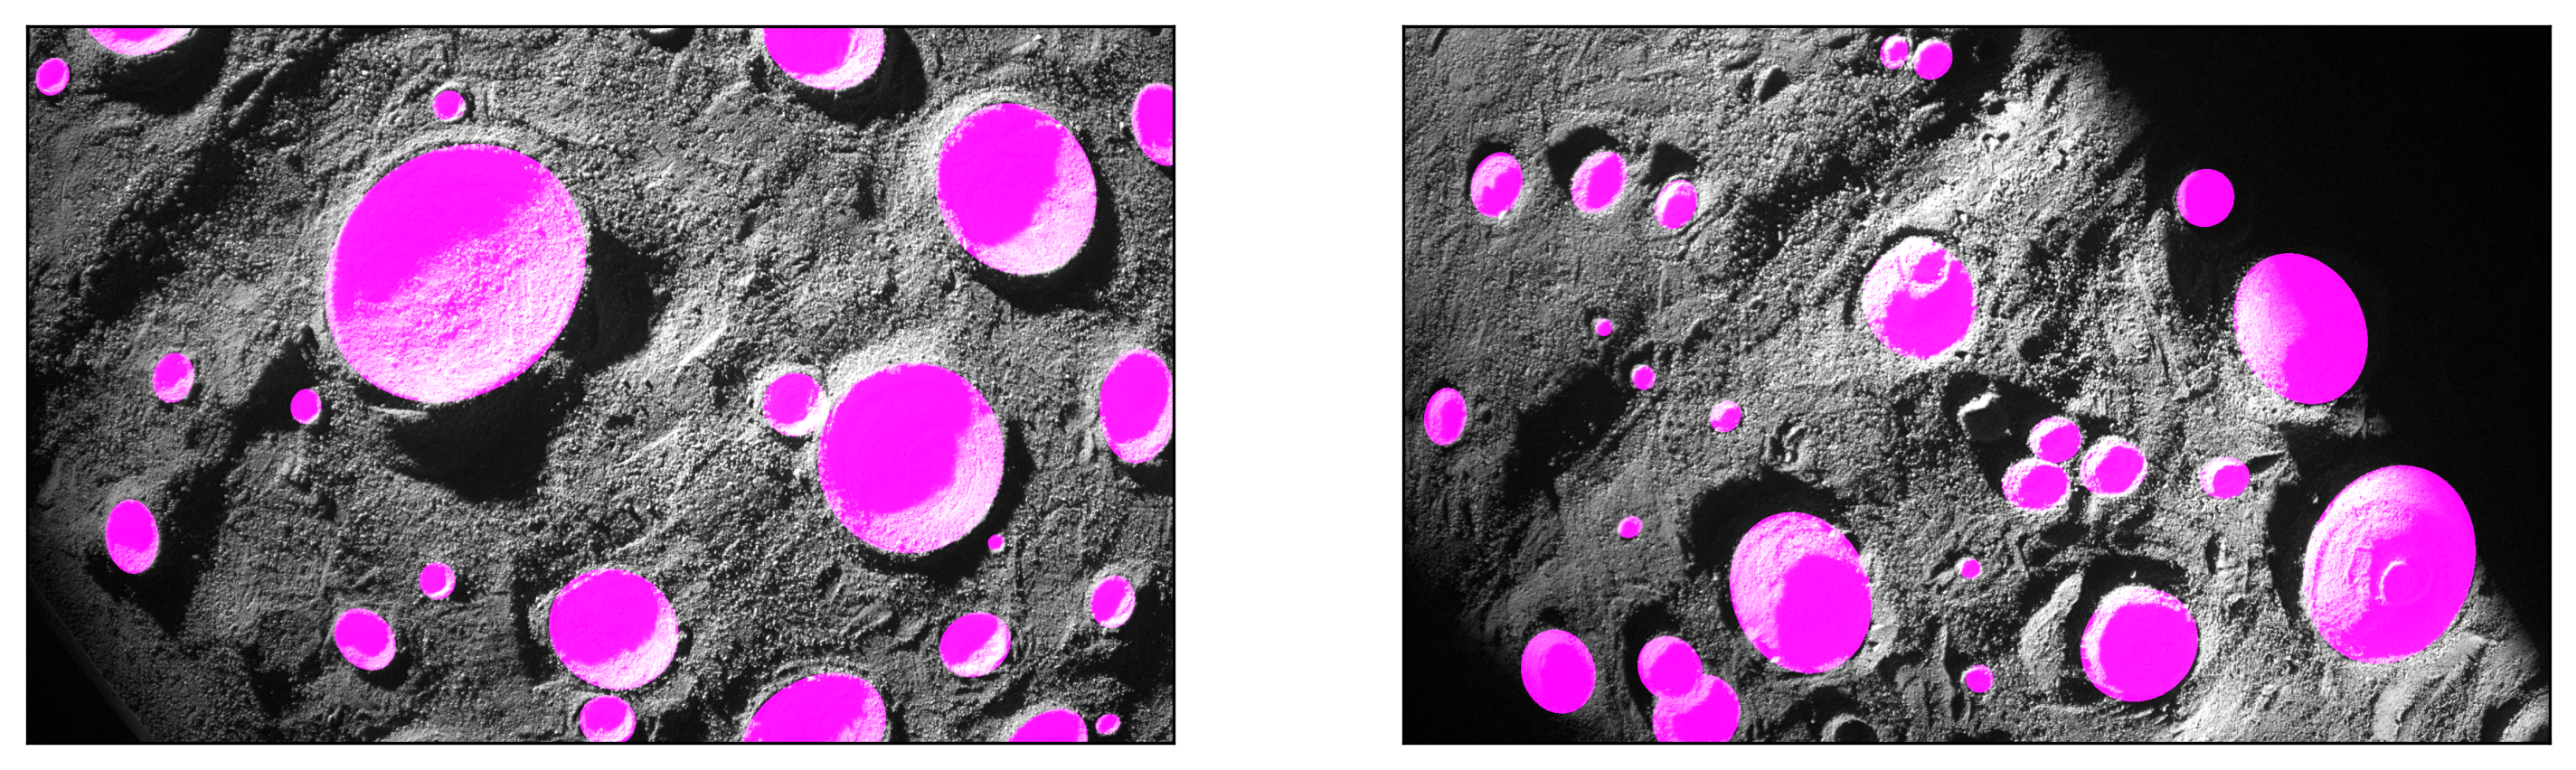

In [20]:
# Show a random sample of images
n_samples = 2
fig, ax = plt.subplots( ncols = n_samples )

for i in range( n_samples ):
    img, target = cd.__getitem__( int( np.random.rand() * cd.__len__() ) )
    img = img.numpy()[0]
    img = np.stack( ( img, img, img ), axis = 2 )

    for mask in target['masks']:
        img[:,:,0] += mask.numpy()
        img[:,:,2] += mask.numpy()

    ax[i].imshow( img )
    ax[i].set_xticks( [] )
    ax[i].set_yticks( [] )
    # ax[i].set_title( 'Angle: {angle:d}, Sample: {sample:d}'.format( angle = target['view_angle'][0].item(), sample = target['image_id'].item() ) )
plt.show()

In [21]:
# Return the batch as an iterable, skipping 'None' samples
def collate_fn(batch):
    # Ensure batch is a list and filter out None entries
    batch = list(filter(lambda x: x is not None, batch))
    return tuple(zip(*batch))  # Unpack and zip non-None samples

In [22]:
# Split the dataset into train and test
trainIndices, testIndices = cd.testSplit()
print( 'Training samples:', len( trainIndices ) )
print( 'Testing samples:', len( testIndices ) )

dataset_train = torch.utils.data.Subset( cd, trainIndices )
dataset_test = torch.utils.data.Subset( cd, testIndices )

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size = 4,
    shuffle = True,
    num_workers = 2,
    collate_fn = partial(collate_fn),
    persistent_workers=True
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size = 8,
    shuffle = False,
    num_workers = 11,
    collate_fn = collate_fn
)

Training samples: 336
Testing samples: 42


In [23]:
for i, (img, target) in enumerate(data_loader):
    print(f"Batch {i}: Loaded {len(img)} images and {len(target)} targets")

# for i in range(len(dataset_train)):
#     try:
#         img, target = dataset_train[i]
#         print(f"Sample {i} loaded successfully.")
#     except Exception as e:
#         print(f"Error loading sample {i}: {e}")

Traceback (most recent call last):
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "<string>", line 1, in <module>
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    exitcode = _main(fd, parent_sentinel)
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'collate_fn' on <module '__main_

RuntimeError: DataLoader worker (pid(s) 26533) exited unexpectedly

In [ ]:
initial_lr = 1e-2
momentum = 0.9
weight_decay = 0.0005

model.to( device )
params = [ p for p in model.parameters() if p.requires_grad ]
optimizer = SGD( params, lr = initial_lr, momentum = momentum, weight_decay = weight_decay )
scheduler = ReduceLROnPlateau( optimizer, patience = 5, cooldown = 2 )
# Early stopping????

In [ ]:
# Make metrics dict with the required keys
def init_run_metrics():
    return dict(
        train = dict(
            batch = list(),
            loss_total = list(),
            loss_classifier = list(),
            loss_box_reg = list(),
            loss_objectness = list(),
            loss_rpn_box_reg = list(),
            loss_mask = list(),
        ),
        valid = dict(
            batch = list(),
            loss_total = list(),
            loss_classifier = list(),
            loss_box_reg = list(),
            loss_objectness = list(),
            loss_rpn_box_reg = list(),
            loss_mask = list(),
        ),
    )

In [ ]:
model.train()

for img, target in data_loader:
    img = [image.to(device) for image in img]  # Move images to device

    # Ensure target contains only labels, boxes, and masks
    target = [
        {
            'boxes': (t['boxes']).to(device) if 'boxes' in t else None,
            'labels': (t['labels']).to(device) if 'labels' in t else None,
            'masks': (t['masks']).to(device) if 'masks' in t else None,
        }
        for t in target
    ]

    # Remove any None values (if boxes, labels, or masks were not present)
    target = [t for t in target if t['boxes'] is not None or t['labels'] is not None or t['masks'] is not None]

    out = model(img, target)
    break

# Forward pass


In [ ]:
out

In [ ]:
model_name = 'mask_rcnn'

start_e = 1
EPOCHS = 50

run_metrics = init_run_metrics()

for e in range(start_e, EPOCHS + start_e):
    train_loader, validation_loader, test_loader = ( data_loader, data_loader_test, data_loader_test )

    print(f'\n-----Epoch {e} started-----\n')

    since = time.time()

    model.train()
    bar = tq( train_loader, desc = f"Training [{e}]",
                postfix = {
                    "loss_total": 0.,
                    "loss_classifier": 0.,
                    "loss_box_reg": 0.,
                    "loss_ellipse": 0.,
                    "loss_objectness": 0.,
                    "loss_rpn_box_reg": 0.,
                } )
    
    for batch, ( images, targets ) in enumerate( bar, 1 ):
        images = list( image.to( device ) for image in images )
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model( images, targets )
        loss = sum( l for l in loss_dict.values() )

        if not math.isfinite(loss):
            del images, targets
            raise RuntimeError(f"Loss is {loss}, stopping training")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        postfix = dict( loss_total = loss.item() )
        run_metrics["train"]["loss_total"].append( loss.item() )
        run_metrics["train"]["batch"].append( batch )

        for k, v in loss_dict.items():
            postfix[k] = v.item()
            run_metrics["train"][k].append( v.item() )

        bar.set_postfix(ordered_dict=postfix)

    with torch.no_grad():
        bar = tq(validation_loader, desc=f"Validation [{e}]",
                    postfix={
                        "loss_total": 0.,
                        "loss_classifier": 0.,
                        "loss_box_reg": 0.,
                        "loss_ellipse": 0.,
                        "loss_objectness": 0.,
                        "loss_rpn_box_reg": 0
                    })
        for batch, (images, targets) in enumerate(bar, 1):
            images = list( image.to( device ) for image in images )
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model( images, targets )
            loss = sum(l for l in loss_dict.values())

            if not math.isfinite(loss):
                del images, targets
                raise RuntimeError(f"Loss is {loss}, stopping validation")

            postfix = dict(loss_total=loss.item())
            run_metrics["valid"]["loss_total"].append(loss.item())
            run_metrics["valid"]["batch"].append(batch)

            for k, v in loss_dict.items():
                postfix[k] = v.item()
                run_metrics["valid"][k].append(v.item())

            bar.set_postfix(ordered_dict=postfix)

    time_elapsed = time.time() - since

    scheduler.step( mean( run_metrics["valid"]["loss_total"][(e - 1) * len(validation_loader):e * len(validation_loader)] ) )

    state_dict = {
        'epoch': e,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'run_metrics': run_metrics,
    }

    images, targets = next(iter(test_loader))
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    print(
        f"\nSummary:\n",
        f"\tEpoch: {e}/{EPOCHS + start_e - 1}\n",
        f"\tAverage train loss: {mean(run_metrics['train']['loss_total'][(e - 1) * len(train_loader):e * len(train_loader)])}\n",
        f"\tAverage validation loss: {mean(run_metrics['valid']['loss_total'][(e - 1) * len(validation_loader):e * len(validation_loader)])}\n",
        f"\tDuration: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
    )
    
    joblib.dump( run_metrics, 'training_metrics/' + model_name )

    if e % 1 == 0:
        torch.save( model.state_dict(), 'training_checkpoints/' + model_name + '_' + str( e ) + '.blob' )
        print(f'Saved Model Checkpoint\n')
    print(f'-----Epoch {e} finished.-----\n')

In [ ]:
run_metrics = joblib.load( './training_metrics/mask_rcnn' )

In [ ]:
epoch_losses_combined = []

for s in [ 'train', 'valid' ]:
    epoch_losses = {}
    n_batches = np.max( run_metrics[s]['batch'] )
    keys = list( run_metrics[s].keys() )[1:] # Skip the batch number

    # Collect average losses per key per epoch
    for key in keys:
        l = []
        for i in range( len( run_metrics[s][key] ) ):
            l.append( np.mean( run_metrics[s][key][i * n_batches:( i + 1 ) * n_batches] ) )
        epoch_losses[key] = l
    epoch_losses_combined.append( epoch_losses )

# Plot average loss per epoch
fig, ax = plt.subplots( ncols = 3, nrows = 2 )
for i, row in enumerate( ax ):
    for j, col in enumerate( row ):
        col.plot( epoch_losses_combined[0][keys[i*3 + j]] ) # Train Loss
        col.plot( epoch_losses_combined[1][keys[i*3 + j]] ) # Validation Loss
        col.legend( [ 'Train', 'Validation' ] )
        col.set_title( keys[i*3 + j] )
        col.grid( alpha = 0.4 )
        col.set_xlabel( 'Epoch' )
        col.set_ylabel( 'Loss' )
        col.set_xticks( np.arange( 0, EPOCHS + 1, 5 ) )
fig.tight_layout()
plt.show()

In [ ]:
np.argsort( epoch_losses_combined[1]['loss_total'] )

In [ ]:
path = "training_checkpoints/mask_rcnn_6.blob"
model.load_state_dict( torch.load( path ) )
model.eval()
model.to( device )
print( 'Loaded:', path )

In [ ]:
model.eval()

predictions = []

with torch.no_grad():
    bar = tq( data_loader_test )
    for batch, ( images, targets ) in enumerate( bar, 1 ):
        images = list( image.to( device ) for image in images )
        targets = [ { k: v.to( device ) for k, v in t.items() } for t in targets ]
        preds = model( images )

        # Preds is a list of dicts
        for p in preds:
            for item in p.values():
                print( item )
                item.to( 'cpu' ) # Put each output onto the cpu
        predictions.extend( preds )

In [ ]:
# Show a random sample of predictions
n_samples = 4
fig, ax = plt.subplots( ncols = n_samples )

pred_threshold = 0.7

for i in range( n_samples ):
    test_set_index = int( np.random.rand() * len( testIndices ) )
    dataset_index = testIndices[test_set_index]
    img, target = cd.__getitem__( dataset_index )
    img = img.numpy()[0]
    img = np.stack( ( img, img, img ), axis = 2 )
    
    # Apply prediction confidence mask
    mask = predictions[test_set_index]['scores'] > 0.7
    
    img = plot_ellipses( img, target['boxes'], target['ellipse_matrices'] )
    img = plot_ellipses( img, predictions[test_set_index]['boxes'][mask], predictions[test_set_index]['ellipse_matrices'][mask], color = ( 0, 1, 0 ) )

    ax[i].imshow( img )
    ax[i].set_xticks( [] )
    ax[i].set_yticks( [] )
    # ax[i].set_title( 'Angle: {angle:d}, Sample: {sample:d}'.format( angle = target['view_angle'][0].item(), sample = target['image_id'].item() ) )
plt.show()

In [ ]:
model.train()
device = torch.device( 'cpu' )
model.to( device )

img, target = cd.__getitem__( 2000 )
out = model( img.unsqueeze( 0 ).to( device ), [ target ] )[0]

img = img.numpy()[0]
img = np.stack( ( img, img, img ), axis = 2 )

# Apply prediction confidence mask
mask = out['scores'] > 0.0

img = plot_ellipses( img, target['boxes'], target['ellipse_matrices'] )

for bbox, ellipse in zip( out['boxes'][mask], out['ellipse_sparse'][mask] ):
    color = ( np.random.rand(), np.random.rand(), np.random.rand() )
    
    cv2.rectangle(
            img,
            ( int( bbox[0] ), int( bbox[1] ) ),
            ( int( bbox[2] ), int( bbox[3] ) ),
            color,
            2,
        )
    
    cv2.ellipse(
        img,
        ( int( ellipse[0].item() ), int( ellipse[1].item() ) ),
        ( int( ellipse[2].item() / 1.4 ), int( ellipse[3].item() / 1.4 ) ),
        ellipse[4].item() * math.pi / 180,
        0, # Start Angle for drawing
        360, # End Angle for drawing
        color,
        2,
    )

    print( ellipse[0:2], ( bbox[0] + bbox[2] ) / 2, ( bbox[1] + bbox[3] ) / 2 )

    # print( 
    #     ellipse[0].item() - ( ( bbox[0].item() + bbox[2].item() ) / 2 ),
    #     ellipse[1].item() - ( ( bbox[1].item() + bbox[3].item() ) / 2 )
    # )

plt.imshow( img )
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['figure.dpi'] = 200

In [ ]:
device = torch.device( 'cpu' )
model.to( device )
model.eval()

print( model.training )

img, target = cd.__getitem__( 2000 )
out = model( img.unsqueeze( 0 ).to( device ), [ target ] )[0]

img = img.numpy()[0]
img = np.stack( ( img, img, img ), axis = 2 )

# Apply prediction confidence mask
mask = out['scores'] > 0.0

img = plot_ellipses( img, target['boxes'], target['ellipse_matrices'] )

for bbox, ellipse in zip( out['boxes'][mask], out['ellipse_sparse'][mask] ):
    color = ( np.random.rand(), np.random.rand(), np.random.rand() )
    
    cv2.rectangle(
            img,
            ( int( bbox[0] ), int( bbox[1] ) ),
            ( int( bbox[2] ), int( bbox[3] ) ),
            color,
            2,
        )
    
    cv2.ellipse(
        img,
        ( int( ellipse[0].item() ), int( ellipse[1].item() ) ),
        ( int( ellipse[2].item() ), int( ellipse[3].item() ) ),
        ellipse[4].item() * math.pi / 180,
        0, # Start Angle for drawing
        360, # End Angle for drawing
        color,
        2,
    )

plt.imshow( img )
plt.show()